# Main

This file contains everything you need to run the model. This requires already be in csv format in the "data/clean" directory.

You must run everything in "scripts" before running this file.

In [6]:
import os
import numpy as np
import pandas as pd

## Visualize paths

A little janky, but works.

Dropdown(description='Select CSV:', options=('gazebo_trajectory2D-2_100.csv', 'gazebo_trajectory2D-2_1000.csv'…

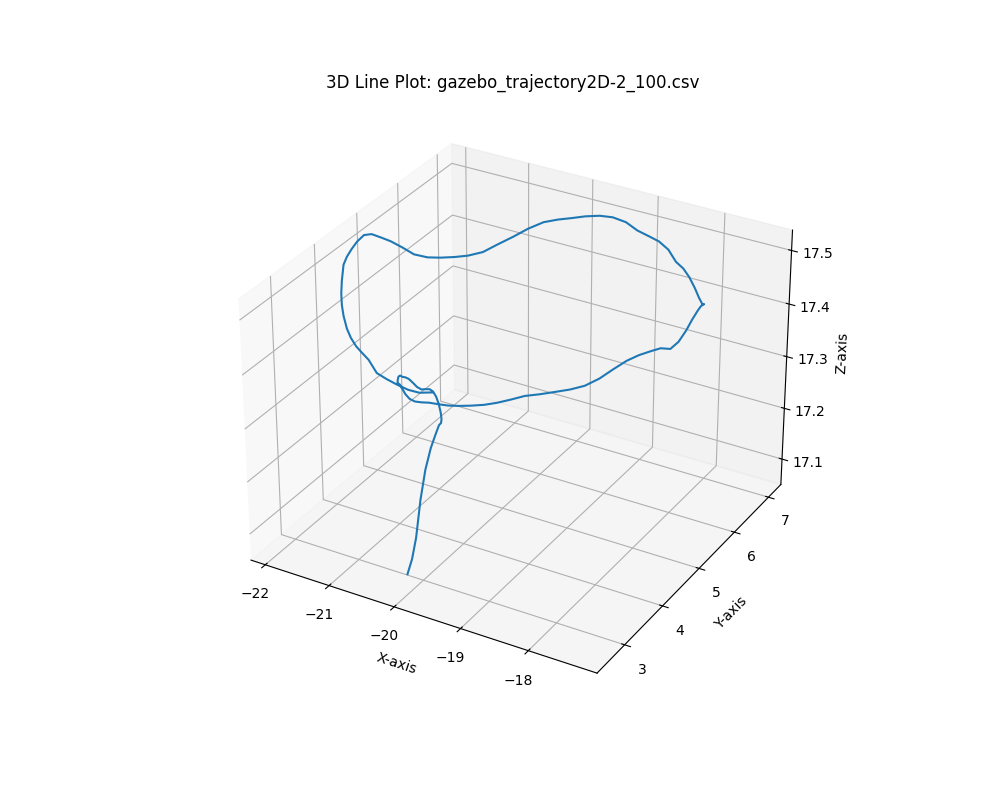

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display
import glob
import os

%matplotlib widget

def create_interactive_3d_plot(directory="."):
    """
    Creates an interactive 3D line plot allowing selection of multiple CSV files
    and rotation of the view.

    Args:
        directory (str): The directory to search for CSV files.
    """

    # Get a list of all CSV files in the specified directory
    csv_files = glob.glob(os.path.join(directory, "*.csv"))
    if not csv_files:
        print(f"No CSV files found in {os.path.abspath(directory)}")
        return

    # Create a dropdown widget for file selection
    file_dropdown = widgets.Dropdown(
        options=[os.path.basename(f) for f in csv_files],
        description="Select CSV:",
        disabled=False,
    )

    # Initial plot setup
    # We will initialize the plot here, but will create the actual line inside
    # the update function to ensure it's always refreshed.
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    def update_plot(change):
        # Access 'new' attribute from the change dictionary for the selected value
        selected_file_name = change["new"]
        file_path = os.path.join(directory, selected_file_name)

        try:
            df = pd.read_csv(file_path)

            if "tx" not in df.columns or "ty" not in df.columns or "tz" not in df.columns:
                ax.clear() # Clear any previous plot or error message
                ax.text2D(0.5, 0.5, f"Error: '{selected_file_name}' missing 'tx', 'ty', or 'tz' columns.",
                          transform=ax.transAxes, ha="center")
                fig.canvas.draw_idle()
                return

            # Clear the entire axes before plotting new data.
            # This is crucial because we're drawing a new line and resetting view.
            ax.clear()

            # Plot the new data. ax.plot returns a list of line objects,
            # so we use line, = to unpack the single line object.
            # 'line' will now correctly reference the new plot.
            line = ax.plot(df["tx"], df["ty"], df["tz"])[0]

            # Update labels and title
            ax.set_xlabel("X-axis")
            ax.set_ylabel("Y-axis")
            ax.set_zlabel("Z-axis")
            ax.set_title(f"3D Line Plot: {selected_file_name}")

            # Ensure data limits are set correctly for the new data
            x_min, x_max = df["tx"].min(), df["tx"].max()
            y_min, y_max = df["ty"].min(), df["ty"].max()
            z_min, z_max = df["tz"].min(), df["tz"].max()

            # Add a small buffer to the limits for better visualization
            x_buffer = (x_max - x_min) * 0.05
            y_buffer = (y_max - y_min) * 0.05
            z_buffer = (z_max - z_min) * 0.05

            ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
            ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
            ax.set_zlim(z_min - z_buffer, z_max + z_buffer)

            # Redraw the plot canvas
            fig.canvas.draw_idle()

        except Exception as e:
            ax.clear() # Clear any previous plot or error message
            ax.text2D(0.5, 0.5, f"Error loading or plotting {selected_file_name}: {e}",
                      transform=ax.transAxes, ha="center")
            fig.canvas.draw_idle()

    # Link the dropdown to the update function
    file_dropdown.observe(update_plot, names="value")

    # Display the dropdown and the initial plot
    display(file_dropdown)

    # Trigger initial plot with the first file
    # Manually create a dictionary that mimics the 'change' object structure
    initial_change_event = {"new": file_dropdown.value}
    update_plot(initial_change_event)

    plt.show()

# To use this function:
# 1. Make sure you have ipywidgets installed: pip install ipywidgets
# 2. Run this code in a Jupyter Notebook or JupyterLab.
# 3. Create some dummy CSV files for testing with 'timestamp', 'tx', 'ty', 'tz' columns.
#    Example:
#    df1 = pd.DataFrame({'timestamp': range(10), 'tx': [i for i in range(10)], 'ty': [i*2 for i in range(10)], 'tz': [i*3 for i in range(10)]})
#    df1.to_csv('data1.csv', index=False)
#    df2 = pd.DataFrame({'timestamp': range(10), 'tx': [i for i in range(10)], 'ty': [10-i for i in range(10)], 'tz': [i*0.5 for i in range(10)]})
#    df2.to_csv('data2.csv', index=False)

# Call the function. By default, it looks for CSVs in the current directory.
# You can specify a different directory: create_interactive_3d_plot("/path/to/your/data")
create_interactive_3d_plot(directory="../data/clean/riotu-labs")

## Resample the data and derive velocity

The fpv-uzh and mid-air datasets have different sample rates and formats. This code is meant to resample everything to 10hz (sample time = 0.1sec). This function also removes the rotation data from the fpv-uzh dataset.

The sample rate is can actually be thought of as a hyperparameter for our model. For now, we are following the VECTOR GRU paper.

The model can either be trained on positional or velocity data.

In [ ]:
def resample(df: pd.DataFrame, sampling_time: float):
    df = df.sort_values("timestamp")
    new_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), sampling_time)
    
    # Interpolate tx, ty, tz values at the new timestamps
    new_tx = np.interp(new_timestamps, df['timestamp'], df['tx'])
    new_ty = np.interp(new_timestamps, df['timestamp'], df['ty'])
    new_tz = np.interp(new_timestamps, df['timestamp'], df['tz'])
    
    # Create a new DataFrame with the resampled trajectory
    df_resampled = pd.DataFrame({
        'timestamp': new_timestamps,
        'tx': new_tx,
        'ty': new_ty,
        'tz': new_tz
    })
    
    return df_resampled

def velocity(df: pd.DataFrame):
    out = pd.DataFrame(columns=["timestamp", "vx", "vy", "vz"])
    dt = df["timestamp"].diff()

    out["timestamp"] = df["timestamp"]
    out["vx"] = df["tx"].diff() / dt
    out["vy"] = df["ty"].diff() / dt
    out["vz"] = df["tz"].diff() / dt

    return out.iloc[1:]

# resample everything in "data/clean" and save in "resampled"
out_path_pos = "../data/resampled"
out_path_vel = "../data/velocity"
os.makedirs(out_path_pos, exist_ok=True)
os.makedirs(out_path_vel, exist_ok=True)

def walk_and_process(root_path="../data/clean"):
    for dirpath, dirnames, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.endswith("csv") or filename.endswith("txt"):
                df = pd.read_csv(os.path.join(dirpath, filename))
                res = resample(df, 0.1)
                vel = velocity(res)
                res.to_csv(os.path.join(out_path_pos, filename))
                vel.to_csv(os.path.join(out_path_vel, filename))
    
    
walk_and_process()

## Split data

5-fold stratified cross validation. Must be stratified because training data comes from different distributions.